# Librerias

In [2]:
library(bnlearn)
library(Rgraphviz)
library(repr)
library(gRain)

# Funciones

In [33]:
resample_train = function(tabla, r, n, algor){
    ptm <- proc.time()
    
    rankings = vector(mode="list")
    ais = vector(mode="list")
    
    m = nrow(tabla)
    cat("Nº filas en cada resampling:", round(m*r))
    cat("\n\n")
    
    if(algor == "hc"){
        aux = function(x){hc(x)}
    }
    if(algor == "tabu"){
        aux = function(x){tabu(x)}
    }
    
    for(i in 1:n){
        i = sample(m, size = round(m*r), replace = FALSE)
        
        options(warn=-1)
        dag = aux(tabla[i,])
        strength = arc.strength(dag, data = tabla[i,], criterion = "bic") # x2, aic...
        options(warn=0)
        
        for(i in get_nodos_aislados(dag)){
            if(is.null(ais[[i]])){
                ais[[i]] = 1
            }else{
                ais[[i]] = ais[[i]] + 1
            }
        }
        
        rank = t(apply(strength[,1:2], 1, sort))
        for(i in 1:nrow(rank)){
            nombre = paste(rank[i,1], rank[i,2], sep=" <-> ")
            if(is.null(rankings[[nombre]])){
                rankings[[nombre]] = c(i)
            }else{
                rankings[[nombre]] = c(rankings[[nombre]], i)
            }
        }
    }
    print(proc.time() - ptm)
    return(list(rankings, ais))
}

get_nodos_aislados = function(dag){
    nodos_aislados = c()
    for(i in bnlearn::nodes(dag)){
        padres = bnlearn::parents(dag, i)
        hijos = bnlearn::children(dag, i)
        if(length(padres)==0 & length(hijos)==0){
            nodos_aislados = c(nodos_aislados, i)
        }
    }
    return(nodos_aislados) 
}

add_single_to_blacklist = function(blacklist, node, names){
    b1 <- data.frame(from = names, to = node)
    b2 <- data.frame(to = names, from = node)
    return(rbind(blacklist, b1, b2))
}

remove_isolated_nodes = function(dag){
    for(i in get_nodos_aislados(dag)){
        dag = remove.node(dag, i)
    }
    return(dag)
}

# Datos

In [7]:
# tabla = read.csv("data/ARIA_cleaned/PlanRT.csv", row.names=1)
# tabla = read.csv("data/ARIA_cleaned/Sch_categ.csv", row.names=1)
tabla = read.csv("data/ARIA_cleaned/Sch76_cat.csv")
tabla["ScheduledActivitySer"] = NULL

cols = names(tabla)
length(cols)

tabla[cols] <- lapply(tabla[cols], factor)
tabla = tabla[cols]
dim(tabla)
# head(tabla)

[1] 67

[1] 94746    67

# Análisis de robustez (remuestreo)

In [8]:
n = 100
ret = resample_train(tabla, 0.1, n, "hc")
rankings  = ret[[1]]
ais = ret[[2]]

Nº filas en cada resampling: 9475

   user  system elapsed 
  94.24    0.06   95.14 


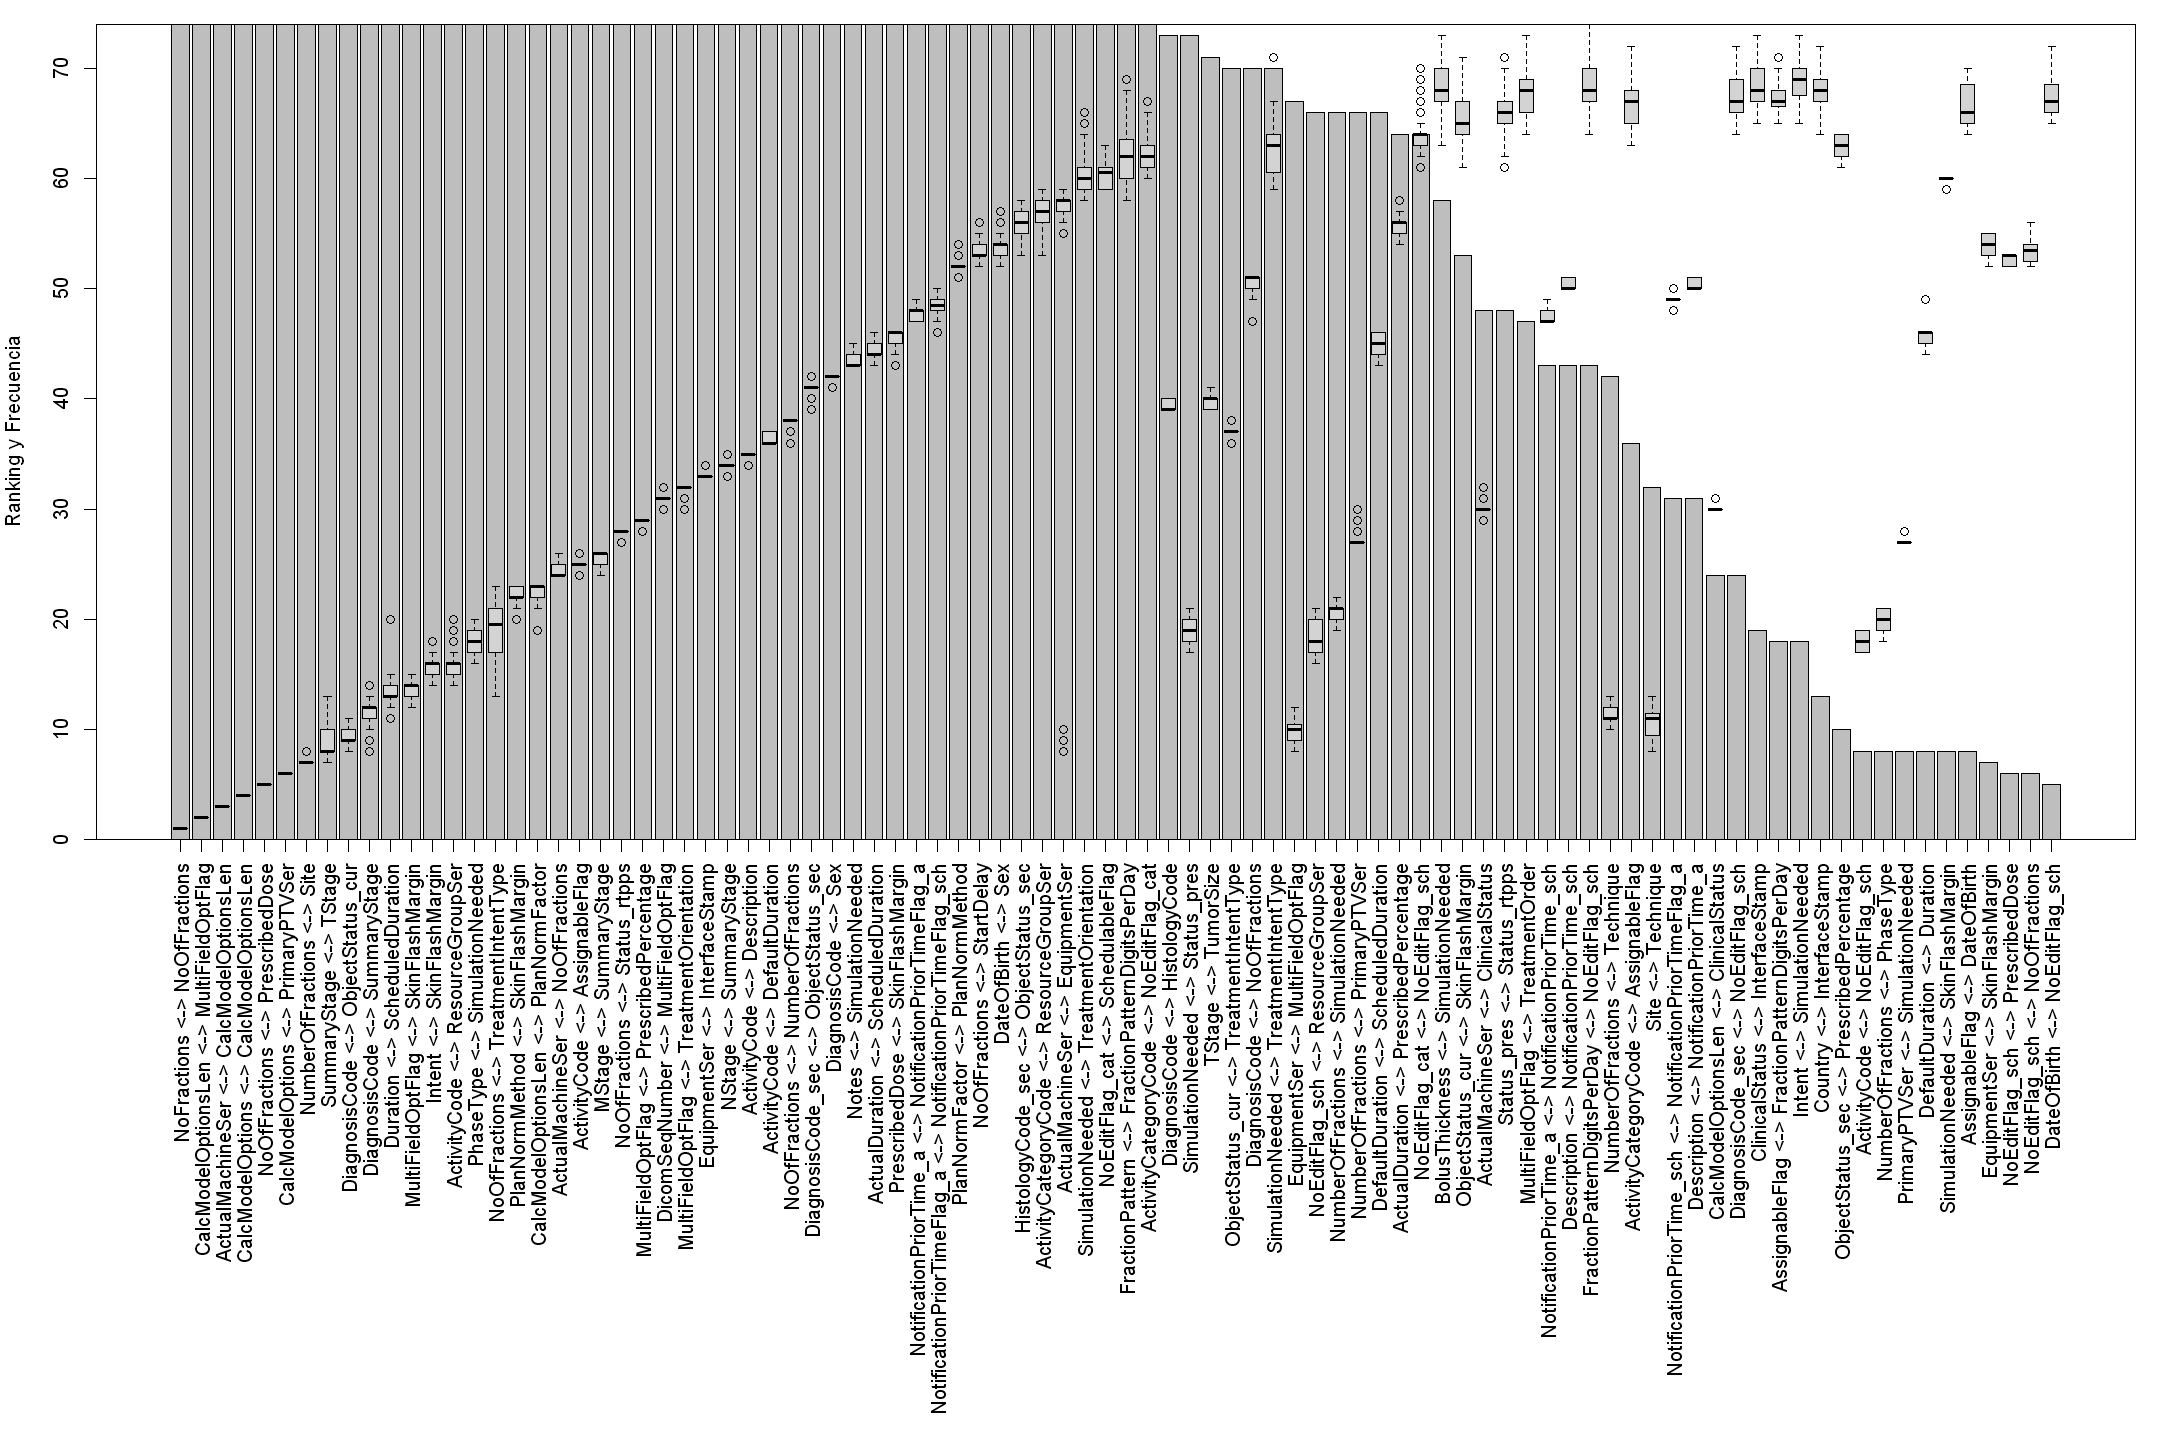

In [9]:
q1 = order(lengths(rankings), mapply(rankings, FUN='median'), decreasing=c(TRUE,FALSE))[0:90]

ylim = max(mapply(rankings, FUN='max'))

frec = lengths(rankings[q1])
frec = mapply(frec, FUN = function(x) round(ylim*x/max(frec)))
              
options(repr.plot.width = 18, repr.plot.height = 12)
par(mar=c(25,4,1,1))
n = barplot(frec, las=3, ylim=c(0, ylim) , ylab = "Ranking y Frecuencia")
boxplot(rankings[q1], at = n, las=3, add=TRUE)

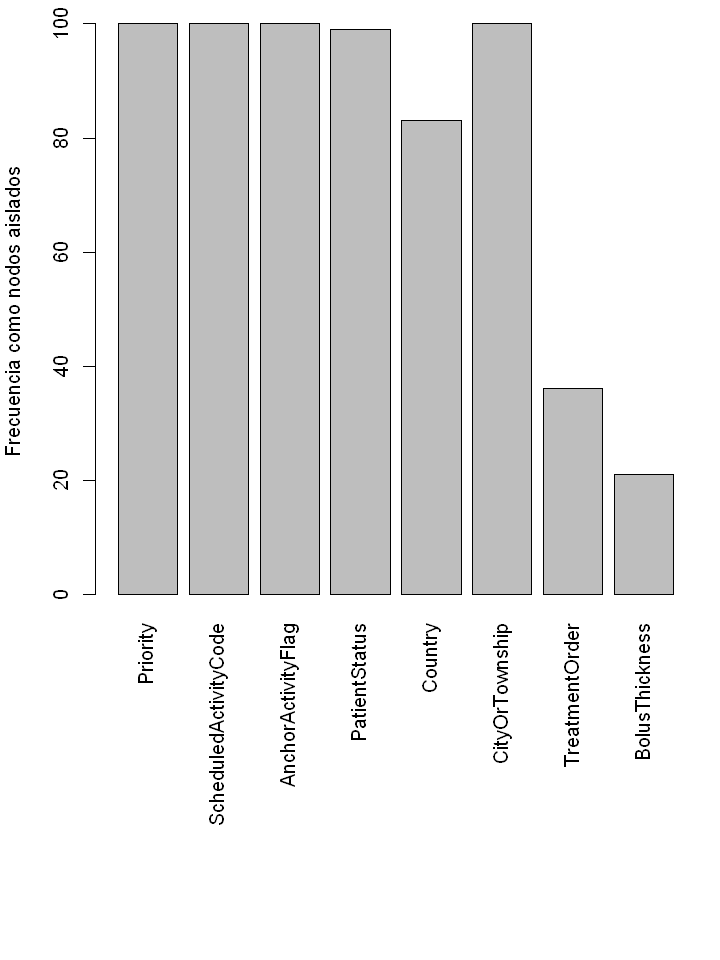

In [10]:
options(repr.plot.width = 6, repr.plot.height = 8)
par(mar=c(15,4,1,1))
barplot(unlist(ais), las=3, ylab='Frecuencia como nodos aislados')

# Blacklist

In [16]:
# creo la blacklist vacia
blacklist = matrix(ncol = 2, dimnames = list(NULL, c("from", "to")))[-1,]

In [17]:
# añado a la blacklist los arcos que salian pocas veces en el remuestreo
for(i in names(frec[frec < 20])){
    aux = strsplit(i, " <-> ")[[1]]
    blacklist = rbind(blacklist, c(aux[1], aux[2]))
    blacklist = rbind(blacklist, c(aux[2], aux[1]))
}

In [18]:
# añado a la blacklist los nodos que salian aislados muchas veces en el remuestreo
for(i in names(ais[ais > 50])){
    blacklist = add_single_to_blacklist(blacklist, i, names(tabla))
}
dim(blacklist)

[1] 834   2

# Construir dag 
Con todos los datos y la blacklist

In [126]:
dag <- tabu(tabla, 
          blacklist = blacklist,
         )
bnlearn::score(dag, data = tabla, type = "bic")

# dag <- tabu(tabla, 
#           blacklist = blacklist,
#          )
# bnlearn::score(dag, data = tabla, type = "bic")

s = arc.strength(dag, data = tabla, criterion = "bic")

[1] -2328709

In [152]:
# dag = remove_isolated_nodes(dag)
# plot(s$strength[2:100])

arcs_fuertes = s[s$strength < -50000, 1:2]
arcs_medios  = s[(s$strength >= -50000) & (s$strength < -20000), 1:2]
dim(arcs_fuertes)
dim(arcs_medios)

[1] 15  2

[1] 16  2

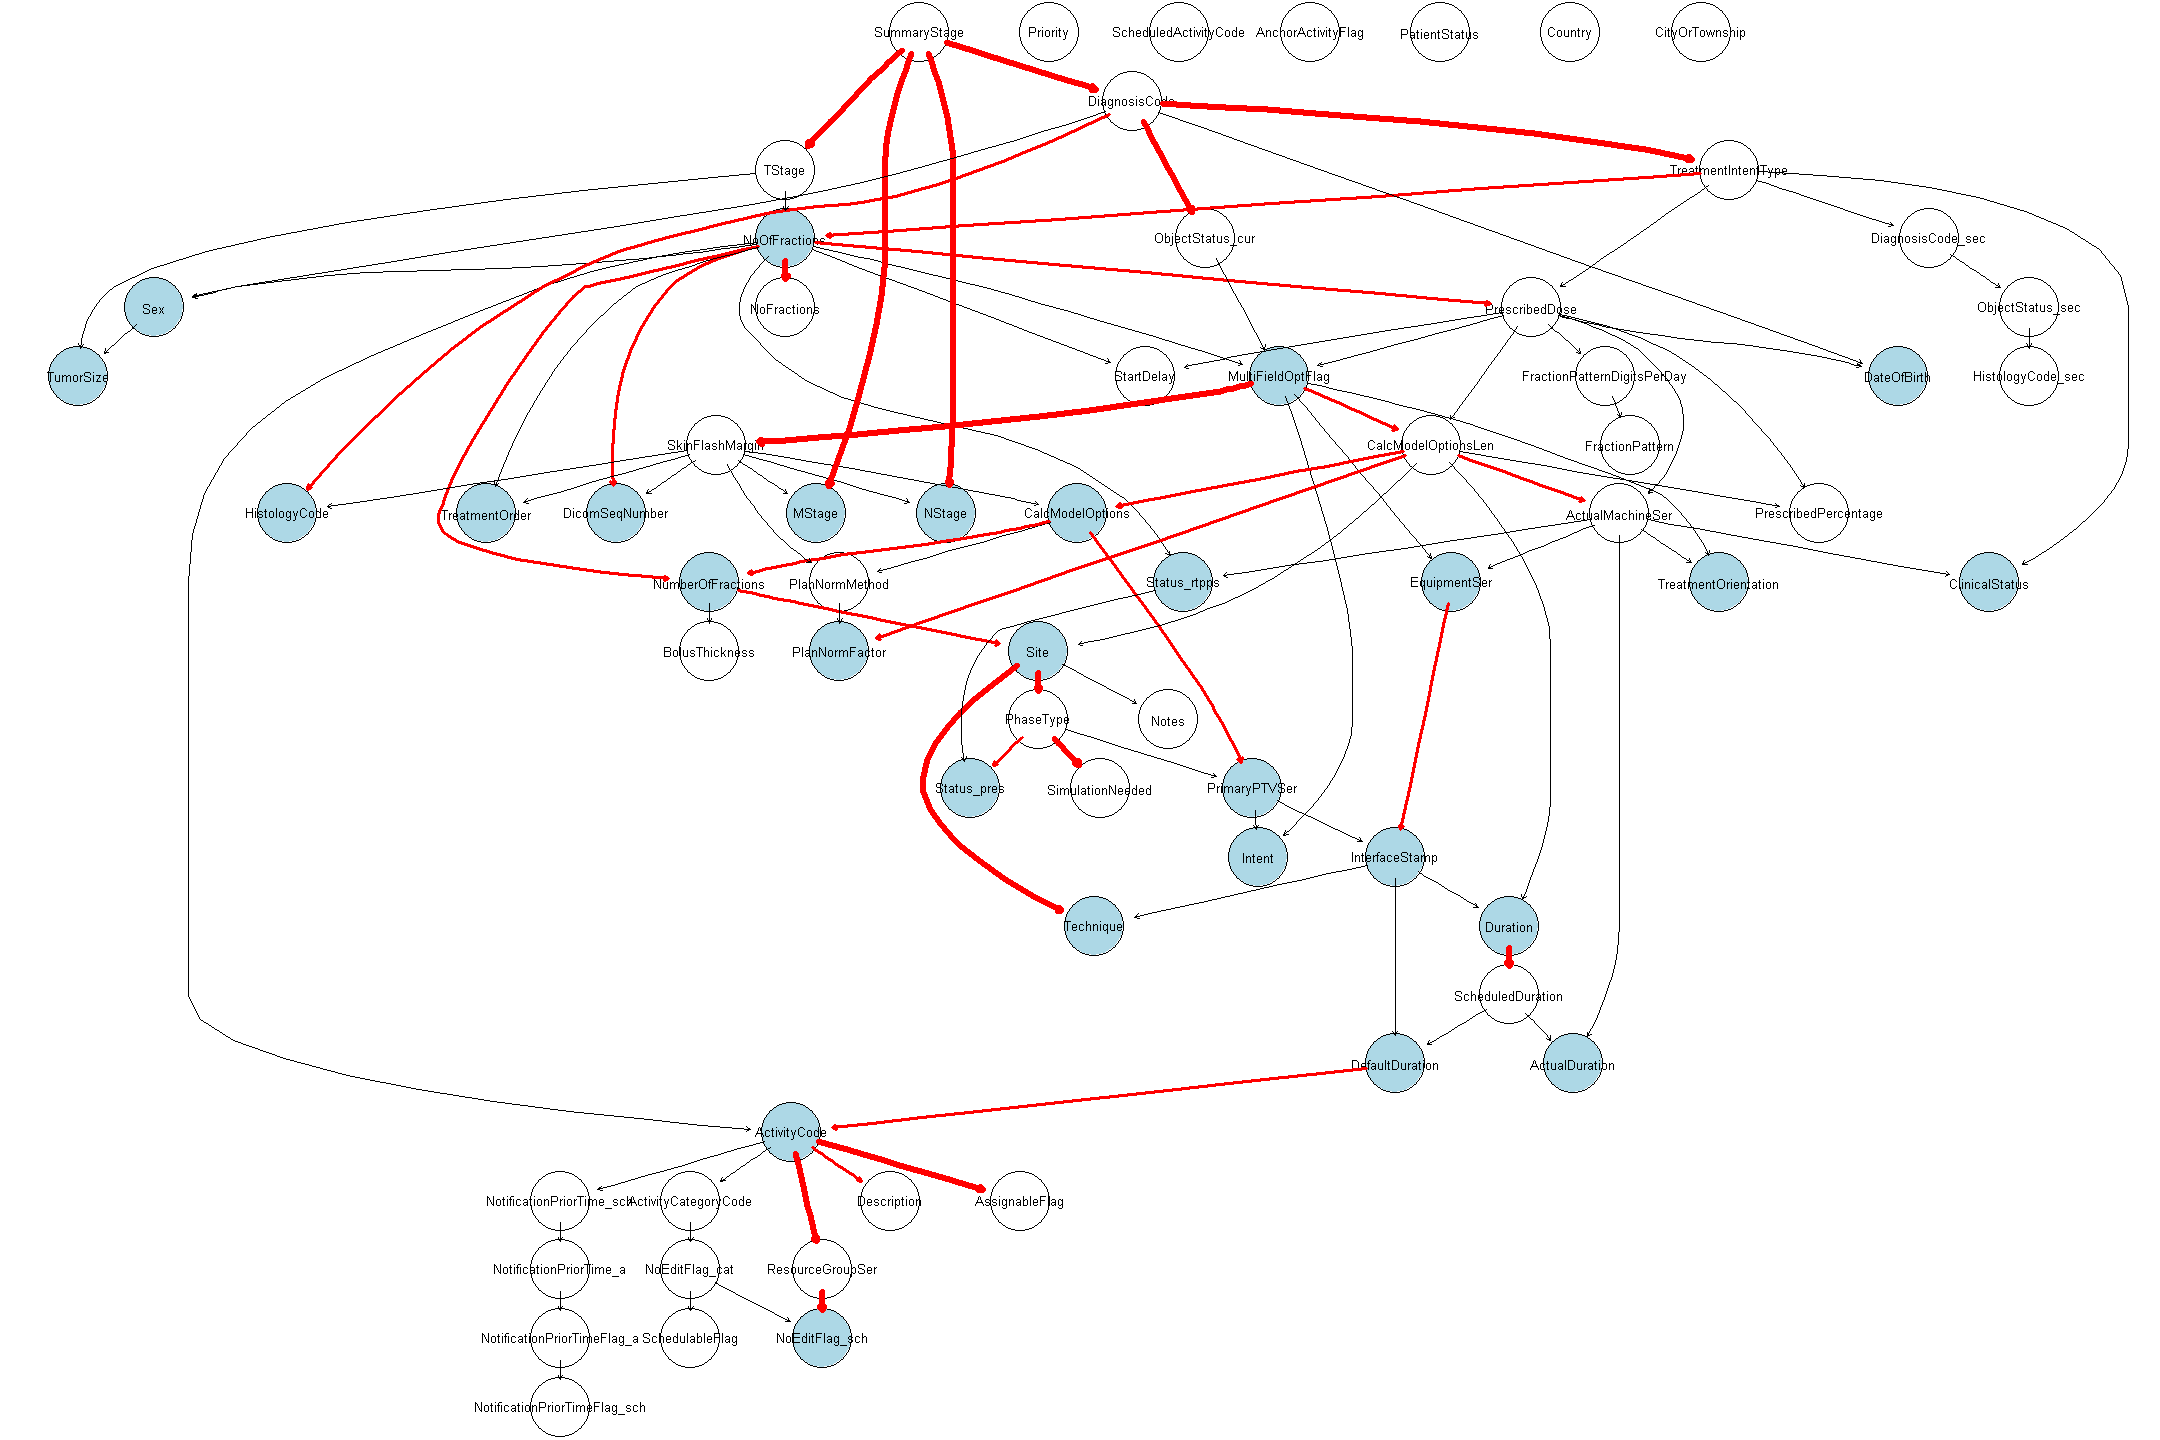

In [154]:
options(repr.plot.width = 18, repr.plot.height = 12)
g = graphviz.plot(dag, render=FALSE)
graph::nodeRenderInfo(g) = list(fontsize=130)

graph::nodeRenderInfo(g)$fill[vstructs(dag)[,2]] = "lightblue"

arcs = paste(arcs_fuertes$from, arcs_fuertes$to, sep = "~")
graph::edgeRenderInfo(g)$col[arcs] = "red"
graph::edgeRenderInfo(g)$lwd[arcs] = 5

arcs = paste(arcs_medios$from, arcs_medios$to, sep = "~")
graph::edgeRenderInfo(g)$col[arcs] = "red"
graph::edgeRenderInfo(g)$lwd[arcs] = 3

Rgraphviz::renderGraph(g)

- **InterfaceStamp**: Indicates whether this plan was
exposed to external interfaces. That is,
it whether the plan was exported or
treated. It was if its value is greater
than 0.

- **CalcModelOptions**: Algorithms and options used in dose
calculation.

- **MultiFieldOptFlag**: For proton treatment only, flag
indicating how field optimization is
performed. Values are:
 TRUE = plan has been created
using simultaneous optimization
of all fields.
 FALSE = Each field has been
optimized individually.

- **DicomSeqNumber**: Used for identifying Fractionation in
the Fractionation sequence in DICOM
environment.

- **StartDelay**: Delay, in days, until the first fraction is
applied.

- **NoFractions**: The number of fractions.

- **PrimaryPTVSer**: Reference to the PatientVolume,
defined as the PrimaryPTV for this
PlanSetup. This PTV defines the
ReferencePercent.

- **PlanNormFactor**: Plan normalization factor is the factor
by which the unnormalized plan dose
must be multiplied to normalize it.
May be given by the user from dose
volume histogram, or automatically
calculated.

- **PhaseType**: How the treatment shall be divided
up in phases.
Refer to
DEFAULT_VALUE_TREATMENT_
PHASE in Lookup data section.
Some of the Possible values are
Primary, Boost, etc.

- **NoEditFlag_sch**: Flag indicates whether the user
can edit this activity. Values are:

- **Status_pres**: Status of Prescription. Some of the
possible values are Draft, Approved,
Retired, etc.

- **NStage**: Indicates the degree to which lymph nodes
are involved with a tumor. N Stage
describes the primary tumor in terms of its
effect on lymph nodes. In the TNM staging
system, N1 through N4 indicate the degree
to which lymph nodes are affected and the
relative localization of the nodes involved.
Default is None.

- **MStage**: Indicates if distant metastases of the
primary tumor exist. In the TNM staging
system, M0 means no distant metastases
and M1 means distant metastases exist.
Default is None.

- **HistologyCode**: Standard code identifying the
type of cells comprising the
tumor.

In [ ]:
# vstructs(dag)

# Aprendizaje de parámetros

In [41]:
bn.bayes <- bn.fit(dag, data = tabla, method = "bayes")
nparams(bn.bayes)

[1] 19700

In [42]:
# bn.bayes$PrescribedPercentage
# bn.bayes$Status_y

# Consultas condicionadas

In [43]:
junction <- compile(as.grain(bn.bayes))

In [44]:
querygrain(junction, nodes = "PrescribedDose")

cond <- setEvidence(junction,
                    nodes = c("DiagnosisCode"),
                    states = c("C34.12          ") )
querygrain(cond, nodes = "PrescribedDose")

cond <- setEvidence(junction,
                    nodes = c("DiagnosisCode","DiagnosisCode_sec"),
                    states = c("C34.12          ",'isNaN') )
querygrain(cond, nodes = "PrescribedDose")

$PrescribedDose
PrescribedDose
   (0.0099, 1.8]    (1.8, 1.9998]    (1.9998, 2.0]     (2.0, 2.001] 
      0.13202513       0.05858904       0.18879699       0.01383708 
    (2.001, 2.2]      (2.2, 2.67]      (2.67, 3.0] (3.0, 9333.7664] 
      0.09730445       0.11166856       0.08030870       0.07978359 
           isNaN 
      0.23768646

$PrescribedDose
PrescribedDose
   (0.0099, 1.8]    (1.8, 1.9998]    (1.9998, 2.0]     (2.0, 2.001] 
      0.15876132       0.06754676       0.24943459       0.01520348 
    (2.001, 2.2]      (2.2, 2.67]      (2.67, 3.0] (3.0, 9333.7664] 
      0.18044555       0.09640622       0.07009239       0.12570056 
           isNaN 
      0.03640913

$PrescribedDose
PrescribedDose
   (0.0099, 1.8]    (1.8, 1.9998]    (1.9998, 2.0]     (2.0, 2.001] 
      0.16684839       0.07074273       0.26077299       0.01525172 
    (2.001, 2.2]      (2.2, 2.67]      (2.67, 3.0] (3.0, 9333.7664] 
      0.18934091       0.09938165       0.06121926       0.10046772 
           isNaN 
      0.03597462

In [45]:
levels(tabla$MStage)

querygrain(junction, nodes = "DiagnosisCode_sec")

[1] "0"     "0(a)"  "0(c)"  "0(e)"  "1"     "1(a)"  "1(c)"  "1a"    "1b"   
[10] "1c"    "isNaN" "X"     "X(a)"  "X(c)"

$DiagnosisCode_sec
DiagnosisCode_sec
 C16.8             C34.32            C50.411           C77.0            
     0.0002643632      0.0003487986      0.0002749176      0.0017947547 
 C77.2             C77.3             C78.00            C78.01           
     0.0001166013      0.0004015707      0.0002221455      0.0028185338 
 C78.4             C78.5             C79.31            C79.40           
     0.0001588189      0.0001166013      0.0087923377      0.0005809959 
 C79.51            C79.82            C79.89            C7B.01           
     0.0085706948      0.0001166013      0.0033145917      0.0011720436 
 C7B.03            C82.05            C85.98           elResto_11_0.0007 
     0.0016681016      0.0001377101      0.0001377101      0.0006759857 
            isNaN 
     0.9683161221